# MAGIC

In [1]:
import numpy as np
import scanpy as sc
from util import normalize_rows, mse

from sklearn.utils.extmath import randomized_svd
import magic
import scprep
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
emt_data = scprep.io.load_csv('/Users/josh/src/noise2self-single-cell/data/magic/HMLE_TGFb_day_8_10.csv.gz')
emt_data = scprep.filter.remove_empty_genes(emt_data)


In [3]:
x1 = np.random.binomial(emt_data.values, 0.5)
x2 = emt_data.values - x1

In [4]:
emt1 = pd.DataFrame(data = x1, index = emt_data.index, columns = emt_data.columns)
emt2 = pd.DataFrame(data = x2, index = emt_data.index, columns = emt_data.columns)

In [5]:
emt1 = scprep.normalize.library_size_normalize(emt1)
#emt1 = scprep.transform.sqrt(emt1)

emt2 = scprep.normalize.library_size_normalize(emt2)
#emt2 = scprep.transform.sqrt(emt2)

In [6]:
genes = ['VIM', 'CDH1', 'ZEB1', 'SNAI1', 'EZH2', 'MYC', 'MT-ND1']

In [7]:
magic_op = magic.MAGIC()
emt_magic = magic_op.fit_transform(emt1, genes=genes)

Calculating MAGIC...
  Running MAGIC on 7523 cells and 28909 genes.
  Calculating graph and diffusion operator...


/Users/josh/.local/lib/python3.6/site-packages/magic/magic.py:376: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn("Input matrix contains unexpressed genes. "


    Calculating PCA...
    Calculated PCA in 29.92 seconds.
    Calculating KNN search...
    Calculated KNN search in 11.01 seconds.
    Calculating affinities...
    Calculated affinities in 3.49 seconds.
  Calculated graph and diffusion operator in 46.18 seconds.
  Calculating imputation...
    Automatically selected t = 8
  Calculated imputation in 1.62 seconds.
Calculated MAGIC in 53.26 seconds.


In [8]:
magic.plot.animate_magic(emt1, gene_x = 'VIM', gene_y = 'CDH1', 
                         gene_color = 'ZEB1', operator=magic_op)

In [9]:
data1 = scprep.select.select_cols(emt1, idx=genes)
data2 = scprep.select.select_cols(emt2, idx=genes)

In [10]:
magic_sweep = [data1]
t_max = 20
for t in range(t_max):
    magic_op.set_params(t=t + 1)
    magic_sweep.append(magic_op.transform(genes=genes))

In [11]:
def mse(x,y):
    return ((x - y)**2).mean()

In [12]:
err = pd.DataFrame([mse(x, data2) for x in magic_sweep])

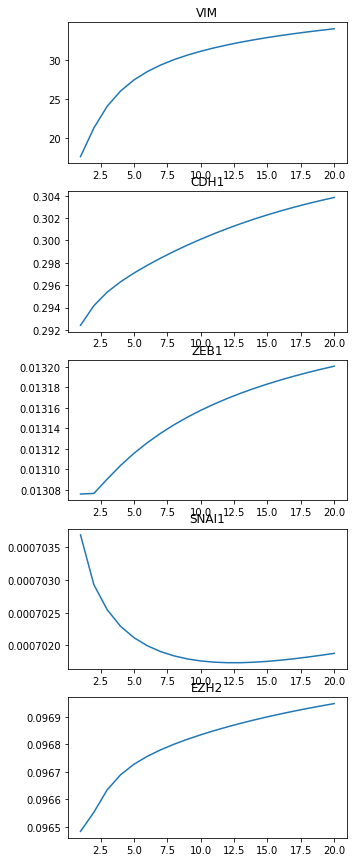

In [13]:
fig, axes = plt.subplots(5, figsize = (5, 15))
for i, ax in enumerate(axes):
    ax.plot(err.iloc[1:,i])
    ax.set_title(err.columns[i])

In [14]:
from scipy.sparse import identity
from copy import deepcopy

In [15]:
lazy_magic_op = deepcopy(magic_op)
lazy_p = 0.5

lazy_magic_op.graph._diff_op = (1 - lazy_p) * lazy_magic_op.diff_op + lazy_p * identity(lazy_magic_op.diff_op.shape[0])

In [16]:
magic_sweep = [data1]
t_max = 20
for t in range(t_max):
    lazy_magic_op.set_params(t=t + 1)
    magic_sweep.append(lazy_magic_op.transform(genes=genes))

In [17]:
err = pd.DataFrame([mse(x, data2) for x in magic_sweep])

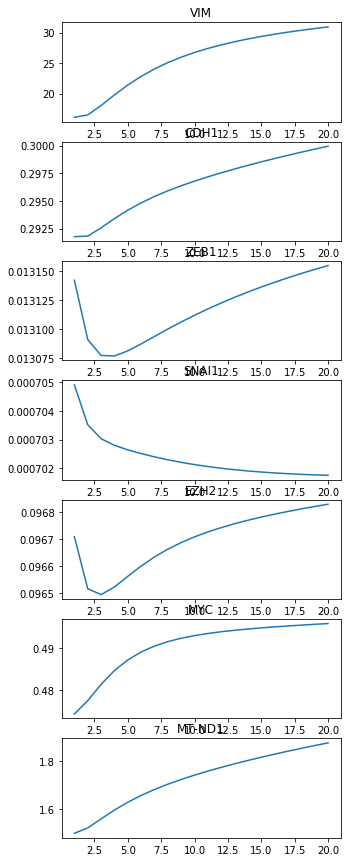

In [18]:
fig, axes = plt.subplots(len(genes), figsize = (5, 15))
for i, ax in enumerate(axes):
    ax.plot(err.iloc[1:,i])
    ax.set_title(err.columns[i])

In [19]:
denoised = magic_sweep[0].copy()
best_err = np.min(err.values, axis = 0)
for g in genes:
    best_t = np.argmin(err[g].values)
    denoised[g] = magic_sweep[best_t][g]

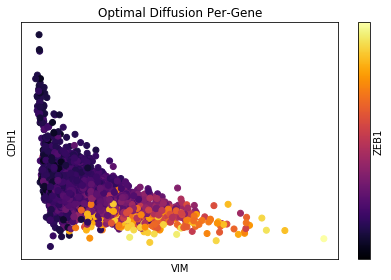

In [20]:
plt.figure()

plt.scatter(denoised['VIM'], denoised['CDH1'], 
            c = denoised['ZEB1'] ,cmap='inferno')

plt.xlabel('VIM')
plt.ylabel('CDH1')
plt.yticks([])
plt.xticks([])
plt.colorbar(label='ZEB1', ticks=[])
plt.title("Optimal Diffusion Per-Gene")
plt.tight_layout()

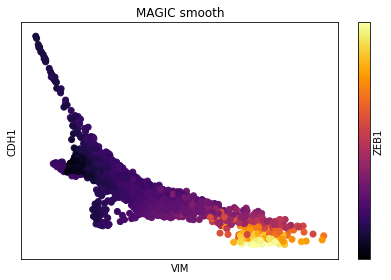

In [21]:
plt.figure()

plt.scatter(magic_sweep[10]['VIM'], magic_sweep[10]['CDH1'], 
            c = magic_sweep[-1]['ZEB1'] ,cmap='inferno')

plt.xlabel('VIM')
plt.ylabel('CDH1')
plt.yticks([])
plt.xticks([])
plt.colorbar(label='ZEB1', ticks=[])
plt.title("MAGIC smooth")
plt.tight_layout()

# Is the data collapsing onto an axis?

Something strange is going on. The magic random walk is not doubly ergodic, ie, it takes probability vectors to probability vectors, but the transpose does not satisfy that. In particular, this means that the fixed point will not be the uniform distribution on the vertices. Things may accumulate sharply.

In [22]:
from scipy.sparse.linalg import eigs
eig_val, eig_v = eigs(magic_op.diff_op, 30)

In [23]:
eig_v[:,0]

array([-0.01152934+0.j, -0.01152934+0.j, -0.01152934+0.j, ...,
       -0.01152934+0.j, -0.01152934+0.j, -0.01152934+0.j])

/Users/josh/anaconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


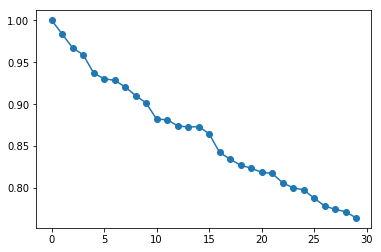

In [24]:
plt.plot(eig_val, marker = 'o')

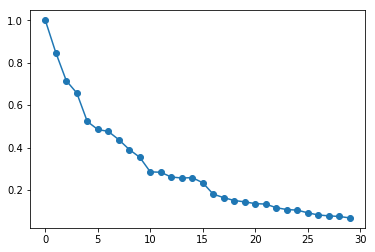

In [25]:
plt.plot(eig_val**10, marker = 'o')

# Compare PCA

In [26]:
x1_norm = emt1.values
x2_norm = emt2.values

U, S, V = randomized_svd(x1_norm, n_components=20, random_state=42)

ss_loss = []
k_range = np.arange(1, 35)
for k in k_range:
    x_pred = U[:,:k].dot(np.diag(S[:k])).dot(V[:k,:])
    ss_loss.append(mse(x_pred, x2_norm))
k_opt = k_range[np.argmin(ss_loss)]
                
print(k_opt)

20


In [27]:
x_pred = U[:,:k_opt].dot(np.diag(S[:k_opt])).dot(V[:k_opt,:])
denoised_pca_all = pd.DataFrame(data = x_pred, index = emt_data.index, columns = emt_data.columns)

In [28]:
denoised_pca = scprep.select.select_cols(denoised_pca_all, idx=genes)
err = mse(data2, denoised_pca)
print(err)

VIM       18.594576
CDH1       0.292682
ZEB1       0.013113
SNAI1      0.000705
EZH2       0.096499
MYC        0.479790
MT-ND1     1.570246
dtype: float64


In [29]:
for i in range(len(best_err)):
    print(genes[i], '\t', best_err[i])

VIM 	 16.138921980133226
CDH1 	 0.29177287962719406
ZEB1 	 0.013076544141063653
SNAI1 	 0.0007017589028549903
EZH2 	 0.09649477602250872
MYC 	 0.4743459782094666
MT-ND1 	 1.4995804566317747


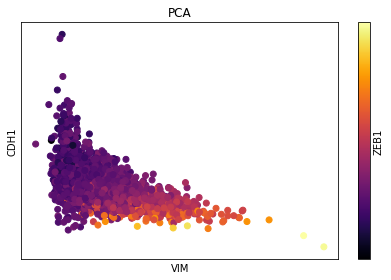

In [30]:
plt.figure()

plt.scatter(denoised_pca['VIM'], denoised_pca['CDH1'], 
            c = denoised_pca['ZEB1'] ,cmap='inferno')

plt.xlabel('VIM')
plt.ylabel('CDH1')
plt.yticks([])
plt.xticks([])
plt.colorbar(label='ZEB1', ticks=[])
plt.title("PCA")
plt.tight_layout()

In [31]:
# Predicted correlation coefficients

corr_magic_per_gene = np.corrcoef(denoised[['CDH1','VIM']].values.T)[0,1]
corr_pca = np.corrcoef(denoised_pca[['CDH1','VIM']].values.T)[0,1]
corr_raw = np.corrcoef(emt1[['CDH1','VIM']].values.T)[0,1]
corr_last_magic = np.corrcoef(magic_sweep[-1][['CDH1','VIM']].values.T)[0,1]

print("Correlations:")
print("Raw \t\t{:.2f}".format(corr_raw))
print("MAGIC per gene \t{:.2f}".format(corr_magic_per_gene))
print("PCA \t\t{:.2f}".format(corr_pca))
print("MAGIC smooth \t{:.2f}".format(corr_last_magic))

Correlations:
Raw 		-0.13
MAGIC per gene 	-0.52
PCA 		-0.48
MAGIC smooth 	-0.88


In [32]:
np.corrcoef(denoised[['CDH1','VIM']].values.T)[0,1], np.corrcoef(denoised_pca[['CDH1','VIM']].values.T)[0,1], \
np.corrcoef(emt1[['CDH1','VIM']].values.T)[0,1], 

(-0.522907475224685, -0.47577339819312786, -0.127268788350834)